Imports

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import deque
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error

Environment

In [ ]:
env = gym.make("CartPole-v1")

Deep Q Learning Algo

- Train the model at each episode on a batch size of past experiences (replay buffer)
- At each training step, take few random past experiences from replay buffer (states, actions, reward, next_states, dones).
- It is convenient to pass only states rather than states-actions pair to model and get states-action pair from which we can take argmax for each state for optimal action.
- Eqn for Q_target : Q_target = r + gamma * max-over-actions (Q(next_state, actions)) -> this Q_target will be used for calculating loss with model's approximated Q value.
- Now calculate Q_target:
- Predict the next Q values using next states and take maximum Q value for each state. Put the values in eqn for Q_target.
- Calculate the approx Q values by passing states to model and calculate loss and gradients. Update the model vars by applying gradients.

- To take action in a environment use a epsilon-greedy-policy to both explore and exploit and perform a step in env. 
- Append these step experiences to a replay buffer so model can use them for training.


In [201]:
def epsilon_greedy_policy(state, epsilon):

    if np.random.rand() < epsilon:
        return np.random.randint(2) #exploring other possibilities
    
    Q_values = model.predict(state[None,:], verbose=0)
    return np.argmax(Q_values[0]) # chosing actiong with max Q value

In [200]:
def get_past_experiences(batch_size):
    ind = np.random.randint(len(replay_buffer), size=batch_size) # selecting batch_size number of past env experience
    states, actions, next_states, rewards, terms, truncs = [
        np.array([replay_buffer[i][j] for i in ind]) for j in range(6)]
    
    return states, actions, next_states, rewards, terms, truncs

In [209]:
def training_step(batch_size):
    past_epx = get_past_experiences(batch_size)
    states, actions, next_states, rewards, terms, truncs = past_epx
    # calculating Q_target values for the actions selected by agent:
    # let's calculate Q prime first
    next_Q_values = model.predict(next_states, verbose=0) # cal Q values for next state-action pair
    max_next_Q_values = np.max(next_Q_values, axis=1) # taking maximum over next-action for each state
    Q_target = rewards + (1 - (terms + truncs)) * discount_factor * max_next_Q_values # there will not be next state for terminal step
    Q_target = Q_target[:,None]
    # create a mask from actions to filter the approximated Q values from the model to consider only taken actions
    mask = tf.one_hot(actions, n_output)

    with tf.GradientTape() as tape:

        Q_values = model(states)
        all_Q.append(Q_values)
        Q_values = tf.reduce_sum(Q_values*mask, axis=1, keepdims=True) # zero out the other actions and collapsing the each array to single value

        loss = tf.reduce_mean(loss_fn(Q_target, Q_values))
        losses.append(loss)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # gradient descent



In [199]:
def play_one_step(env, state, epsilon=0):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, term, trunc, info = env.step(action)

    replay_buffer.append((state, action, next_state, reward, term, trunc))
    
    return next_state, reward, term, trunc, info

In [202]:
batch_size = 32
n_episode = 1000
n_output = env.action_space.n
discount_factor = 0.95
lr = 0.001
loss_fn = mean_squared_error
optimizer = Adam(learning_rate=lr)
replay_buffer = deque(maxlen=2000)
losses = []
ep_reward = []
all_Q = []

model = Sequential([
    Dense(32, activation='elu'),
    Dense(32, activation='elu'),
    Dense(n_output)
])

for episode in range(n_episode):
    obs = env.reset()[0]
    curr_rew = 0
    for step in range(200):
        epsilon = max(1 - episode/(0.8*n_episode) , 0.01) # gradually decreasing epsilon to 0.01 (reducing exploring)
        obs, reward, term, trunc, info =  play_one_step(env, obs, epsilon)
        curr_rew += reward
        if term or trunc:
            break
    ep_reward.append(curr_rew)
    if episode >= 1.5*batch_size: # let the replay buffer populated with enough experiences
        training_step(batch_size)

<Axes: >

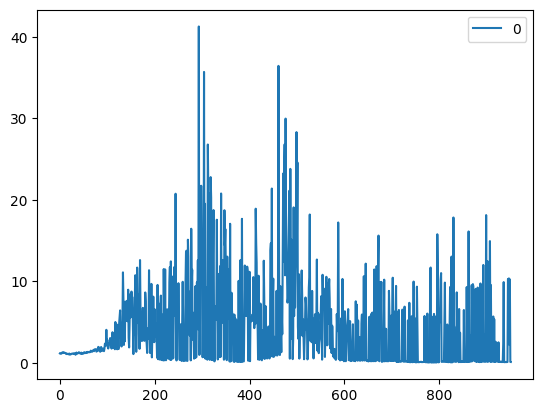

In [203]:
pd.DataFrame(np.array(losses)).plot()

<Axes: >

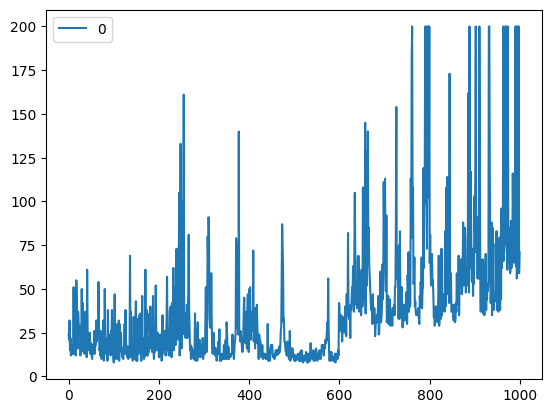

In [204]:
pd.DataFrame(ep_reward).plot()

You can see catastophic forgetting

In [205]:
save_model(model, 'deep-q-learning-model.h5')

In [206]:
env.close()